# Tarea 4 - Redes Neuronales

### Grupo 8:
     - Matías González 5199522-2
     - Leonardo Melgar 5206567-4
     - Emiliano Silva 5127389-8


# 1. Objetivo

Este laboratorio tiene por objetivos:

a) la construcción, utilizando bibliotecas de código abierto, de algoritmos basados en redes neuronales para ser aplicadas sobre un problema de clasificación

b) la evaluación de los modelos construidos


# 2. Diseño

## 2.1 Preparación y División de Conjuntos de Datos para Entrenamiento, Validación y Test

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from lab4 import *

In [2]:
# 1. Cargar el dataset
dataset = pd.read_csv("./lab1_dataset.csv")
preprocessed_dataset = dataset.drop(["cid", "pidnum", "time"], axis=1)
target_column = dataset["cid"]

# Dividir en 80% entrenamiento y 20% test
dataset_train_full, dataset_test, target_train_full, target_test = train_test_split(
    preprocessed_dataset,
    target_column,
    test_size=0.2,
    random_state=42,
    stratify=target_column,
)

# Separar 10% del conjunto de entrenamiento completo para validación
dataset_train, dataset_val, target_train, target_val = train_test_split(
    dataset_train_full,
    target_train_full,
    test_size=0.1,
    random_state=42,
    stratify=target_train_full,
)

Usamos stratify=target_column para asegurar que la proporción de clases en los conjuntos de entrenamiento y prueba sea representativa de la del conjunto de datos original. Esto ocasiona que la distribución de las clases en el conjunto de entrenamiento sea equivalente a la del conjunto completo, lo cual es fundamental en problemas con desbalance de clases.


El conjunto de validación permite ajustar los hiperparámetros sin emplear el conjunto de testeo final, evitando posibles problemas de sobreajuste.


In [3]:
# Mostrar los tamaños de los conjuntos
print(f"Tamaño del conjunto de datos completo: {preprocessed_dataset.shape[0]}")
print(f"Tamaño del conjunto de entrenamiento completo: {dataset_train_full.shape[0]}")
print(f"Tamaño del conjunto de entrenamiento: {dataset_train.shape[0]}")
print(f"Tamaño del conjunto de validación: {dataset_val.shape[0]}")
print(f"Tamaño del conjunto de test: {dataset_test.shape[0]}")

Tamaño del conjunto de datos completo: 2139
Tamaño del conjunto de entrenamiento completo: 1711
Tamaño del conjunto de entrenamiento: 1539
Tamaño del conjunto de validación: 172
Tamaño del conjunto de test: 428


## 2.2 Modelo de Regresión Logística

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Inicializar el escalador
scaler = StandardScaler()

# Ajustar el escalador y transformar los conjuntos de entrenamiento y validación
dataset_train_scaled = scaler.fit_transform(dataset_train)
dataset_val_scaled = scaler.transform(dataset_val)

dataset_train_full_scaled = scaler.fit_transform(dataset_train_full)
dataset_test_scaled = scaler.transform(dataset_test)

# Inicializar el modelo de regresión logística
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

# Entrenar el modelo con el conjunto de entrenamiento
logistic_model.fit(dataset_train_scaled, target_train)

# Realizar predicciones en el conjunto de validación
target_pred_val = logistic_model.predict(dataset_val_scaled)

# Calcular la accuracy en el conjunto de validación
accuracy_val = accuracy_score(target_val, target_pred_val)
print(f"Accuracy en el conjunto de validación: {accuracy_val:.4f}")

Accuracy en el conjunto de validación: 0.8488


### `LogisticRegression`

- Estima la probabilidad de que una observación pertenezca a una clase específica utilizando una función logística, adecuada para clasificación binaria.

- Asume una relación lineal entre las características y el logaritmo de las probabilidades.

- Los coeficientes son fácilmente interpretables en términos de su efecto en la probabilidad de la clase.

- El uso de `StandardScaler` es crucial para asegurar que todas las características tengan igual peso en el modelo.

### Escalado de Datos

Se aplicó `StandardScaler` para estandarizar los datos, transformando las características para que tengan una media de 0 y una desviación estándar de 1.
Se ajustó el escalador `fit_transform` en el conjunto de entrenamiento y luego se aplicó `transform` en el conjunto de validación.

La estandarización de los datos es una práctica común en modelos como regresión logística para asegurar que todas las características tengan la misma escala, lo cual facilita la convergencia y mejora la estabilidad numérica.

Importante no olvidar también escalar el conjunto de test con el mismo escalador `scaler` cuando se haga la evaluación final!

### Entrenamiento del Modelo

Se utilizó `max_iter=1000` para permitir más iteraciones y evitar problemas de convergencia.

Se entrenó el modelo usando el conjunto de datos de entrenamiento escalado `dataset_train_scaled` y sus clases objetivo correspondientes `target_train`.

### Evaluación del Modelo en el Conjunto de Validación

Se utilizó el modelo entrenado para hacer predicciones en el conjunto de validación.

La `accuracy` se calculó comparando las predicciones con las clases verdaderas del conjunto de validación `target_val`, obteniendo un valor de `0.8488`. Este resultado ofrece una estimación de la capacidad del modelo para generalizar a datos no vistos.

## 2.3 Modelos de Redes Neuronales
Para los modelos de redes neuronales se creó la función `train_model`, la cual a partir de distintos parametros crea el modelo, luego lo entrena y finalmente grafica la pérdida y la accuracy
tanto en el conjunto de entrenamiento como en el de validación, en función del número de época.
La función está parametrizada para poder crear y evaluar distintos los modelos que se verán en las siguientes secciones. Los parametros recibidos por la misma son los siguientes:

`input_size`: Especifica el número de características de entrada del modelo, es decir, la cantidad de columnas en los datos de entrada X. Esto define el tamaño de la capa de entrada del modelo.

`hidden_layers`: Permite crear capas ocultas con una cantidad de neuronas específica. El parametro consiste en una lista donde cada elemento indica el número de neuronas que tendrá la capa oculta que corresponde a su lugar en la lista (es decir, nos importa el orden ya que nos indica en cual capa oculta se tendrá ese número de neuronas). Si se pasa una lista vacía ([]), no se crearán capas ocultas.

`output_size`: Define el número de neuronas en la capa de salida del modelo.

`activation_fn`: Es la función de activación que se aplica después de cada capa oculta. Puede ser None para evitar la activación, o una función como nn.ReLU() o nn.Sigmoid().

`loss_fn`: Define la función de pérdida que se utiliza para calcular qué tan lejos está la predicción del modelo del valor real.

`optimizer_fn`: Es una función lambda que devuelve un optimizador. Este optimizador es esencial para entrenar redes neuronales en PyTorch, y realiza los ajustes de los pesos en base al gradiente calculado, usando el método seleccionado (como SGD o Adam) y algunos parámetros como la tasa de aprendizaje o el momentum.

`num_epochs`: Especifica el número de epocas, es decir, cuántas veces el modelo se entrena con el conjunto de datos.

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Paso 2: Definir una función para crear y entrenar el modelo con múltiples capas ocultas
def train_model(input_size, hidden_layers, output_size, activation_fn, loss_fn, optimizer_fn, num_epochs=100, full_evaluation = False):
    # Convertir los datos a tensores de PyTorch
    if (full_evaluation):
        X_train_tensor = torch.tensor(dataset_train_full_scaled, dtype=torch.float32)
        y_train_tensor = torch.tensor(target_train_full.values, dtype=torch.float32 if output_size == 1 else torch.long)
        X_val_tensor = torch.tensor(dataset_test_scaled, dtype=torch.float32)
        y_val_tensor = torch.tensor(target_test.values, dtype=torch.float32 if output_size == 1 else torch.long)
    else:
        X_train_tensor = torch.tensor(dataset_train_scaled, dtype=torch.float32)
        y_train_tensor = torch.tensor(target_train.values, dtype=torch.float32 if output_size == 1 else torch.long)
        X_val_tensor = torch.tensor(dataset_val_scaled, dtype=torch.float32)
        y_val_tensor = torch.tensor(target_val.values, dtype=torch.float32 if output_size == 1 else torch.long)

    # Definir el modelo
    class CustomModel(nn.Module):
        def __init__(self):
            super(CustomModel, self).__init__()
            layers = []

            # Capa de entrada
            last_size = input_size

            # Capas ocultas
            for hidden_size in hidden_layers:
                layers.append(nn.Linear(last_size, hidden_size))
                if activation_fn:  # Añadir activación solo si no es None
                    layers.append(activation_fn)
                last_size = hidden_size

            # Capa de salida (sin activación, se usa sigmoide después)
            layers.append(nn.Linear(last_size, output_size))
            self.model = nn.Sequential(*layers)

        def forward(self, x):
            x = self.model(x)
            if output_size == 1:
                x = torch.sigmoid(x) # La salida es una probabilidad
            return x

    model = CustomModel()

    # Definir la función de pérdida y el optimizador
    criterion = loss_fn
    optimizer = optimizer_fn(model.parameters())

    # Almacenar pérdidas y accuracy
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Entrenamiento del modelo
    for epoch in range(num_epochs):
        # Modo de entrenamiento
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        # Ajustar la función de pérdida según el tipo de salida
        if output_size == 1:  # Clasificación binaria
            loss = criterion(outputs, y_train_tensor.view(-1, 1))
            # Convertir salidas a 0 o 1 para la accuracy
            train_predictions = (outputs > 0.5).float()
        else:  # Clasificación multiclase
            loss = criterion(outputs, y_train_tensor)
            # Usar argmax para obtener la clase con mayor probabilidad
            train_predictions = torch.argmax(outputs, dim=1)
        loss.backward()
        optimizer.step()

        # Evaluación en el conjunto de validación o de test
        model.eval()
        with torch.no_grad():
            train_loss = loss.item()
            val_outputs = model(X_val_tensor)
            if output_size == 1:
                val_loss = criterion(val_outputs, y_val_tensor.view(-1, 1)).item()
                val_predictions = (val_outputs > 0.5).float()
            else:
                val_loss = criterion(val_outputs, y_val_tensor).item()
                val_predictions = torch.argmax(val_outputs, dim=1)

            # Calcular la accuracy
            train_accuracy = (train_predictions.squeeze() == y_train_tensor).float().mean().item()
            val_accuracy = (val_predictions.squeeze() == y_val_tensor).float().mean().item()

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    if (full_evaluation):
        calculate_metrics(y_val_tensor.numpy(), val_predictions.numpy())

    # Graficar la pérdida y la accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

def calculate_metrics(target, predictions):
    print('---------------------------------------------------------------------------')
    print('METRICAS recall, precision y F1')
    accuracy_nn = accuracy_score(target, predictions)
    precision_nn = precision_score(target, predictions)
    recall_nn = recall_score(target, predictions)
    f1_nn = f1_score(target, predictions)
    print(f'Accuracy: {accuracy_nn}')
    print(f'Precision: {precision_nn}')
    print(f'Recall: {recall_nn}')
    print(f'F1: {f1_nn}')
    print('---------------------------------------------------------------------------')

## 2.4 Modelo 2 (sin función de activación y dos salidas)
Para este modelo se espera una red neuronal compuesta por una sola capa lineal (sin función de activación), con dos salidas, una para cada clase objetivo posible del conjunto de datos, siendo entrenado por 100 epocas, utilizando como función de pérdida la función de entropía cruzada (`CrossEntropyLoss`). Vemos a continuación como los resultados que nos devuelve el modelo utilizando la función `train_model` con los parametros correspondientes, y además utilizando como optimizador el algoritmo de Adam con tasa de aprendizaje 0.1:

Epoch 100/100, Training Loss: 0.4697, Validation Loss: 0.4172, Training Accuracy: 0.7804, Validation Accuracy: 0.8488


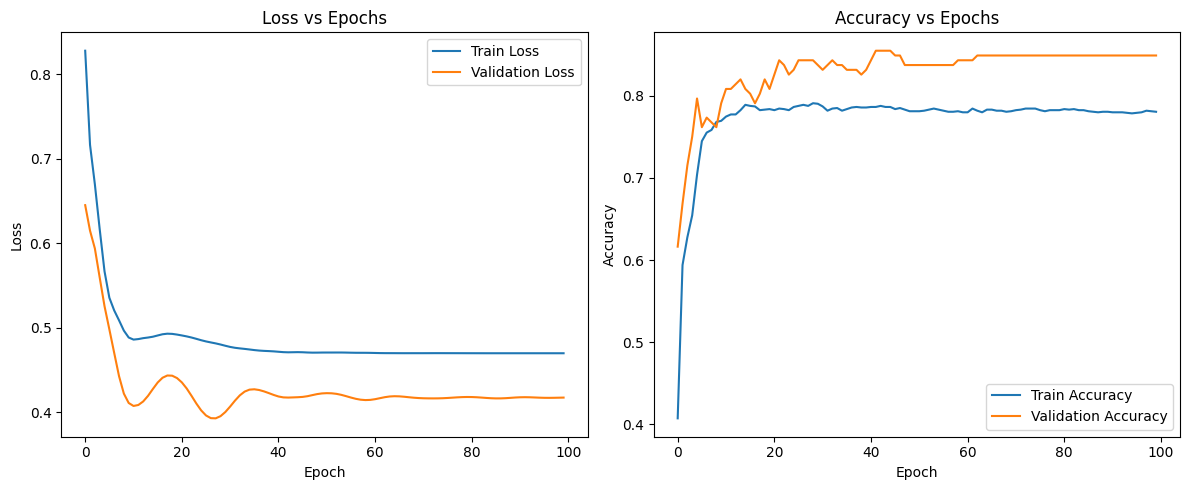

In [ ]:
# Modelo 2
input_size = dataset_train_scaled.shape[1] # Número de características de entrada
hidden_layers = [] # No hay capas ocultas
output_size = 2 # Ya que hay dos salidas (una para cada clase).
activation_fn = None # Porque no hay una función de activación después de la capa de salida
loss_fn = nn.CrossEntropyLoss()
optimizer_fn = lambda params: torch.optim.Adam(params, lr=0.1)
num_epochs = 100

# Entrenar y evaluar el modelo
trained_model2 = train_model(input_size, hidden_layers, output_size, activation_fn, loss_fn, optimizer_fn, num_epochs)
del optimizer_fn

Observamos que se obtienen buenos resultados, dado que obtenemos que la función de pérdida para ambos conjuntos disminuye rápidamente mientras que también la accuracy aumenta para ellos.

Lo segundo que podemos observar es que para el conjunto de validación obtenemos mejores resultado tanto para la funciòn de pérdida como para la accuracy. Lo cual nos indica que el modelo da mejores resultados para aquellos datos con los que no fue entrenado, y nos puede reflejar un buen balance entre ajuste y capacidad de generalización, es decir, que podemos estar evitando un sobreajuste al conjunto de entrenamiento.

Además, a medida que avanzamos epocas, la brecha entre los valores de cada conjunto aumenta (es decir, las lineas tienen mayor distancia entre ellas).
Por otro lado, esta brecha vemos que luego de cierta cantidad de epocas queda con una distancia fija, y además observamos que las gráficas presentan tanto para la accuracy como para la pérdida, un comportamiento que podemos considerar asintótico. Lo que nos sugiere esto es que, a partir de cierto momento el modelo está convergiendo hacia un mínimo, el cual puede ser local o global, y nos indica también el momento en el cual el modelo deja de "aprender". 

Dado que este resultado lo obtenemos ajustando los pesos con el algorimo de Adam con una tasa de aprendizaje de 0.1, lo mejor es ver a continuación como se comporta con las tasas 0.01 y 0.001, y luego utilizando el optimizador SGD con un momentum de 0.9 en lugar de Adam.

Epoch 100/100, Training Loss: 0.4730, Validation Loss: 0.4273, Training Accuracy: 0.7875, Validation Accuracy: 0.8372


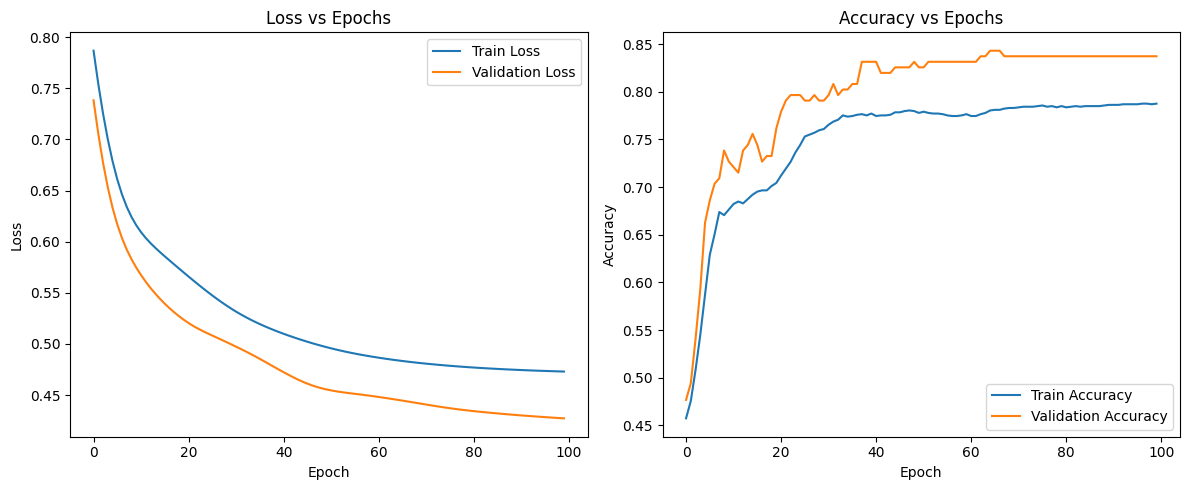

In [222]:
# Entrenar y evaluar el modelo
optimizer_fn = lambda params: torch.optim.Adam(params, lr=0.01)
trained_model2 = train_model(input_size, hidden_layers, output_size, activation_fn, loss_fn, optimizer_fn, num_epochs)
del optimizer_fn

Epoch 100/100, Training Loss: 0.6437, Validation Loss: 0.6203, Training Accuracy: 0.6342, Validation Accuracy: 0.6860


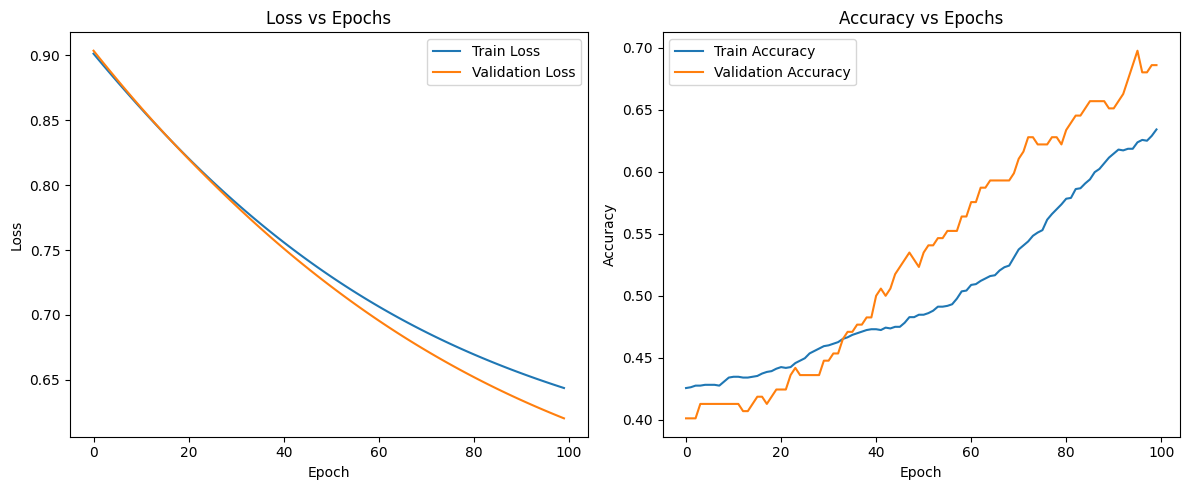

In [223]:
# Entrenar y evaluar el modelo
optimizer_fn = lambda params: torch.optim.Adam(params, lr=0.001)
trained_model2 = train_model(input_size, hidden_layers, output_size, activation_fn, loss_fn, optimizer_fn, num_epochs)
del optimizer_fn

Epoch 100/100, Training Loss: 0.4742, Validation Loss: 0.4279, Training Accuracy: 0.7875, Validation Accuracy: 0.8140


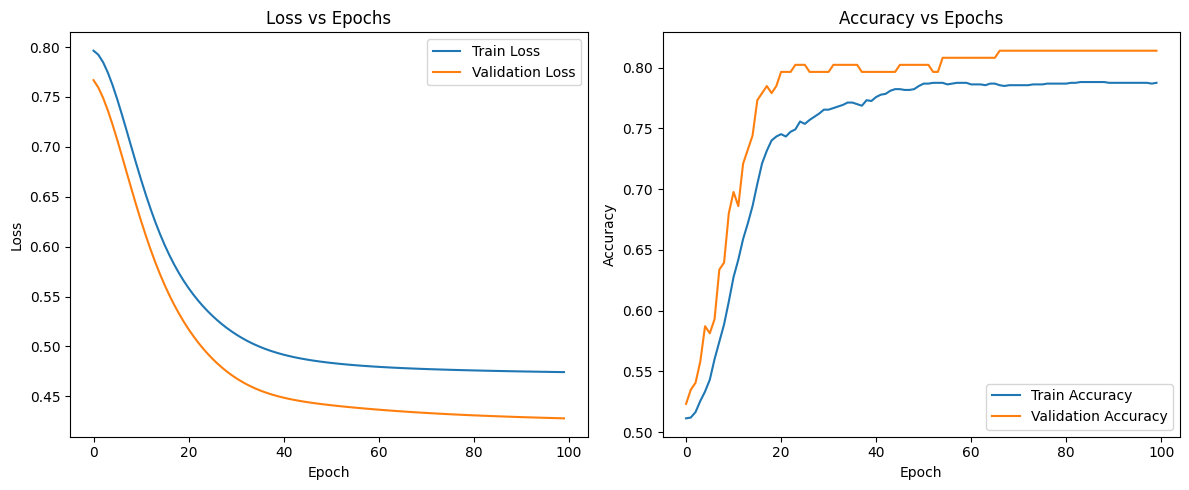

In [224]:
# Entrenar y evaluar el modelo
optimizer_fn = lambda params: torch.optim.SGD(params, lr=0.01, momentum=0.9)
trained_model2 = train_model(input_size, hidden_layers, output_size, activation_fn, loss_fn, optimizer_fn, num_epochs)
del optimizer_fn

Por lo que observamos el mejor resultado lo obtuvimos para la tasa 0.1, pero aún así los resultados obtenidos para la tasa 0.01 y para SGD no son lejanos a los que obtuvimos al principio. Por otro lado notamos que los peores resultados los estaríamos obtneiendo para la tasa 0.001, pero este comportamiento podemos entender que se puede deber a que, para una baja tasa de aprendizaje el modelo actualiza sus pesos en pasos muy pequeños, lo cual impide que llegue a un punto de mínimo en la función de pérdida en un número de épocas razonable (que para nuestro caso es el número 100). Esto último se puede apoyar en observar a continuación que ocurre si aumentamos significativamente el número de épocas:

Epoch 1000/1000, Training Loss: 0.4726, Validation Loss: 0.4280, Training Accuracy: 0.7869, Validation Accuracy: 0.8372


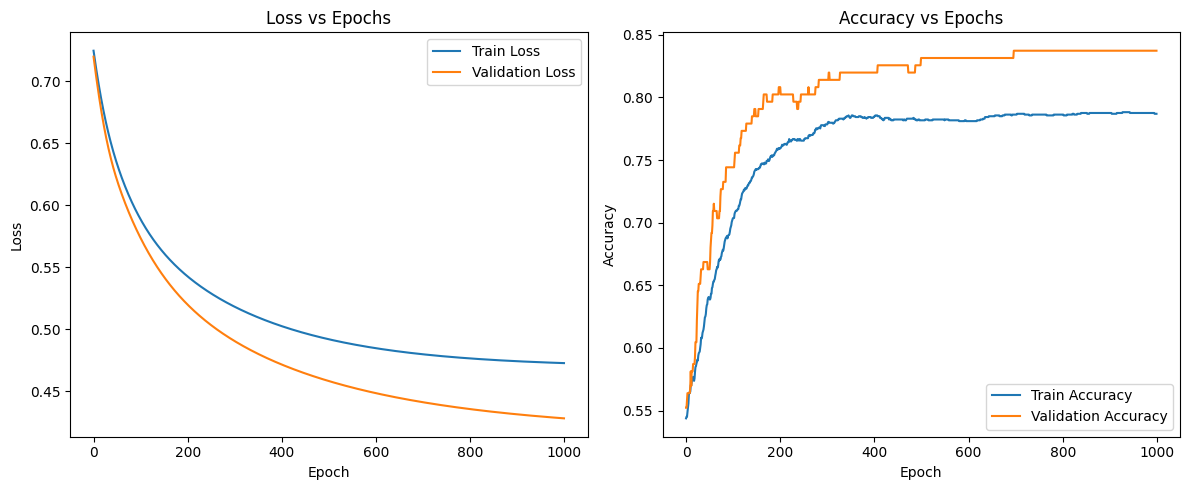

In [216]:
# Entrenar y evaluar el modelo
optimizer_fn = lambda params: torch.optim.Adam(params, lr=0.001)
num_epochs = 1000
trained_model2 = train_model(input_size, hidden_layers, output_size, activation_fn, loss_fn, optimizer_fn, num_epochs)
del optimizer_fn

## 2.4 Modelo 3 (una neurona, activación sigmoide y una salida)
Para este modelo se espera una red neuronal compuesta por una sola neurona, con función de activación sigmoide, y una sola salida, que estime la probabilidad de cada una de las clases objetivo, siendo entrenado por 100 épocas y utilizando como función de pérdida la función de entropía cruzada binaria (`BCELoss`). Observemos a continuación el comportamiento del modelo utilizando (de forma similar a la sección anterior) como optimizador SGD con momentum 0.9 y también el algoritmo Adam con tasas 0.1 y 0.01:

Epoch 100/100, Training Loss: 0.4699, Validation Loss: 0.4175, Training Accuracy: 0.7849, Validation Accuracy: 0.8430


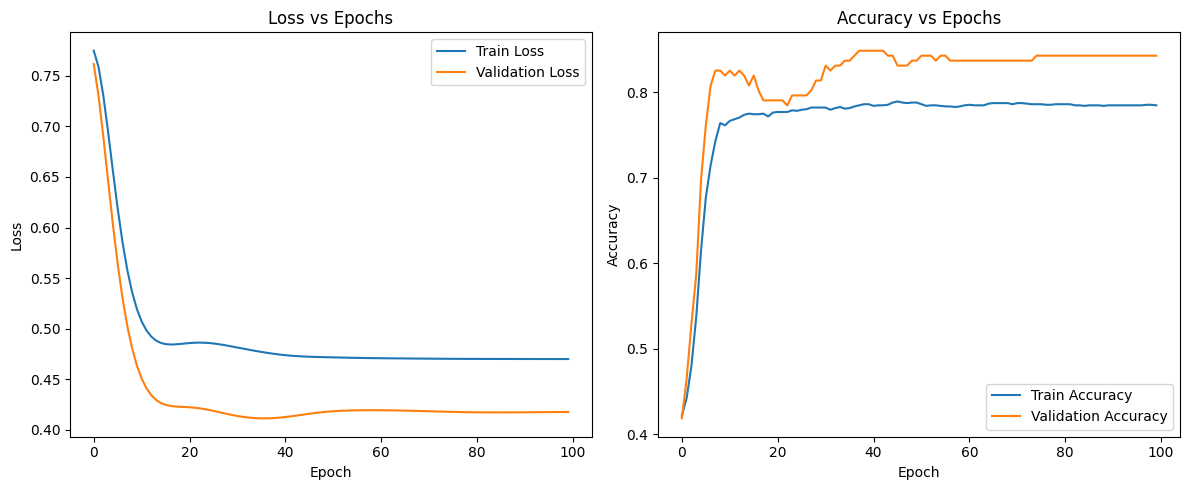

In [ ]:
# Modelo 3
input_size = dataset_train_scaled.shape[1]  # Número de características de entrada
hidden_layers = [] # No hay capas ocultas
output_size = 1 # La salida es la probabilidad de una de las clases
activation_fn = nn.Sigmoid()
loss_fn = nn.BCELoss()
optimizer_fn = lambda params: torch.optim.SGD(params, lr=0.1, momentum=0.9)
num_epochs = 100

# Entrenar y evaluar el modelo
trained_model3 = train_model(input_size, hidden_layers, output_size, activation_fn, loss_fn, optimizer_fn, num_epochs)
del optimizer_fn

Epoch 100/100, Training Loss: 0.5095, Validation Loss: 0.4787, Training Accuracy: 0.7778, Validation Accuracy: 0.8023


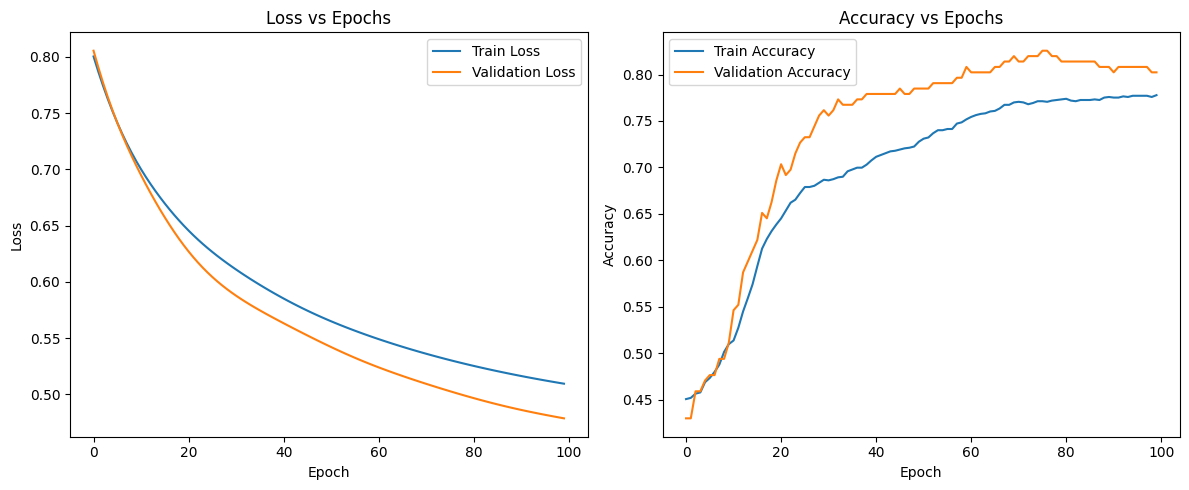

In [226]:
# Entrenar y evaluar el modelo
optimizer_fn = lambda params: torch.optim.Adam(params, lr=0.01)
trained_model2 = train_model(input_size, hidden_layers, output_size, activation_fn, loss_fn, optimizer_fn, num_epochs)
del optimizer_fn

Epoch 100/100, Training Loss: 0.4697, Validation Loss: 0.4173, Training Accuracy: 0.7817, Validation Accuracy: 0.8488


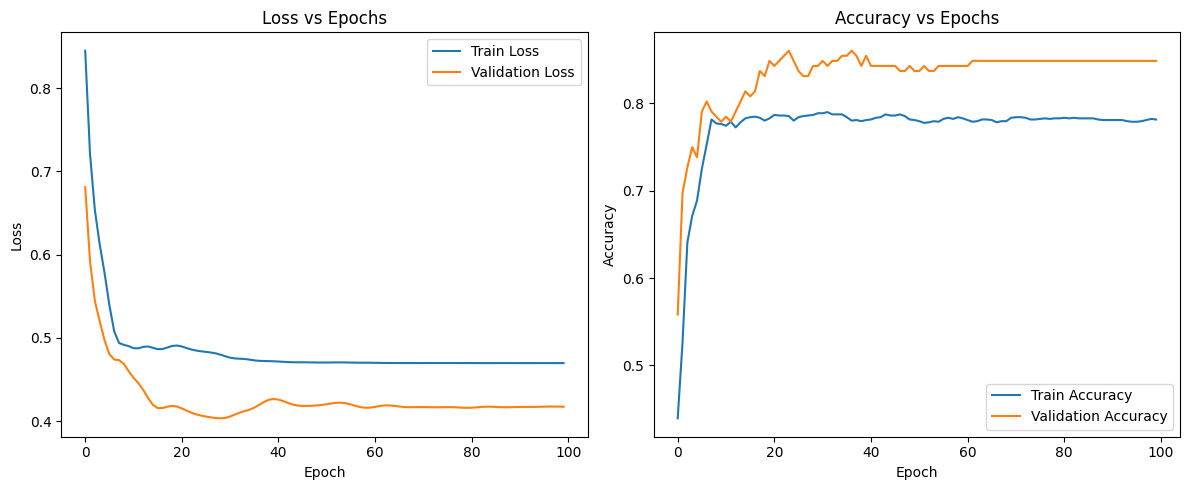

In [177]:
# Entrenar y evaluar el modelo
optimizer_fn = lambda params: torch.optim.Adam(params, lr=0.1)
trained_model2 = train_model(input_size, hidden_layers, output_size, activation_fn, loss_fn, optimizer_fn, num_epochs)
del optimizer_fn

Para este modelo, encontramos que el comportamiento es muy similar al visto para el modelo 2, donde tenemos diferencia en la cantidad de salidas y además en que se agrega la función de activación sigmoide. Aunque podríamos esperar que tenga mejores resultados ya que la activación sigmoide introduce cierta capacidad para capturar relaciones no lineales, pero este no fue el caso. Esto puede deberse a ciertas relaciones lineales en los datos o tambien a algunas limitaciones en el modelo.

## 2.4 Modelo 4 (sin función de activación y dos salidas)
Para este modelo se espera una red neuronal consistente en una red feedforward con una capa oculta de 16 unidades, y que utilice la función sigmoide como activación, que devuelva la probabilidad de cada una de las clases objetivo, y al igual que para el modelo anterior, siendo entrenado por 100 épocas y utilizando como función de pérdida la función de entropía cruzada binaria (`BCELoss`). Veamos a continuación el comportamiento del modelo modificando el optimizador de la misma forma que para el modelo 3:

Epoch 100/100, Training Loss: 0.3475, Validation Loss: 0.5345, Training Accuracy: 0.8525, Validation Accuracy: 0.7674


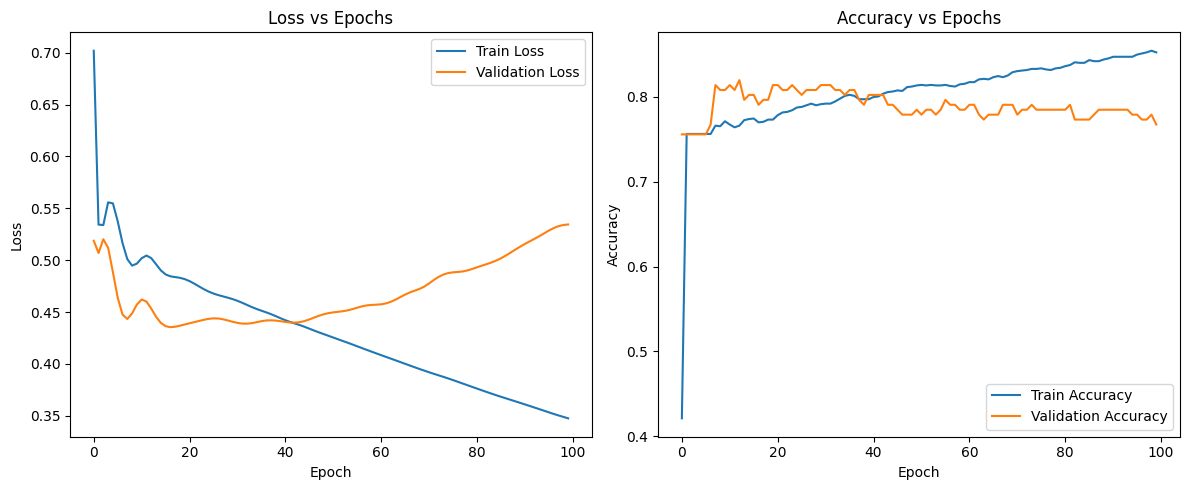

In [253]:
# Modelo 4
input_size = dataset_train_scaled.shape[1]  # Número de características de entrada
hidden_layers = [16]  # Aquí se puede agregar más capas, por ejemplo, [16, 32] para dos capas ocultas
output_size = 1  # La salida es la probabilidad de una de las clases
activation_fn = nn.Sigmoid()
loss_fn = nn.BCELoss()
optimizer_fn = lambda params: torch.optim.Adam(params, lr=0.1)
num_epochs = 100

# Entrenar y evaluar el modelo
trained_model4 = train_model(input_size, hidden_layers, output_size, activation_fn, loss_fn, optimizer_fn, num_epochs)
# trained_model4_full = train_model(input_size, hidden_layers, output_size, activation_fn, loss_fn, optimizer_fn, num_epochs, True)
del optimizer_fn

Epoch 100/100, Training Loss: 0.4687, Validation Loss: 0.4287, Training Accuracy: 0.7862, Validation Accuracy: 0.8314


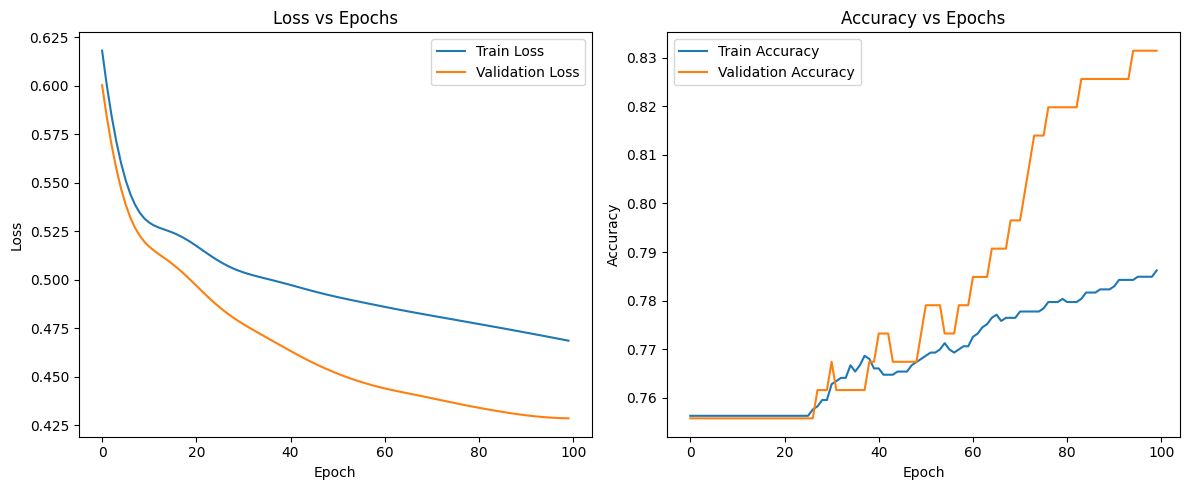

In [236]:
# Entrenar y evaluar el modelo
optimizer_fn = lambda params: torch.optim.Adam(params, lr=0.01)
trained_model4 = train_model(input_size, hidden_layers, output_size, activation_fn, loss_fn, optimizer_fn, num_epochs)
del optimizer_fn

Epoch 100/100, Training Loss: 0.4785, Validation Loss: 0.4216, Training Accuracy: 0.7810, Validation Accuracy: 0.8256


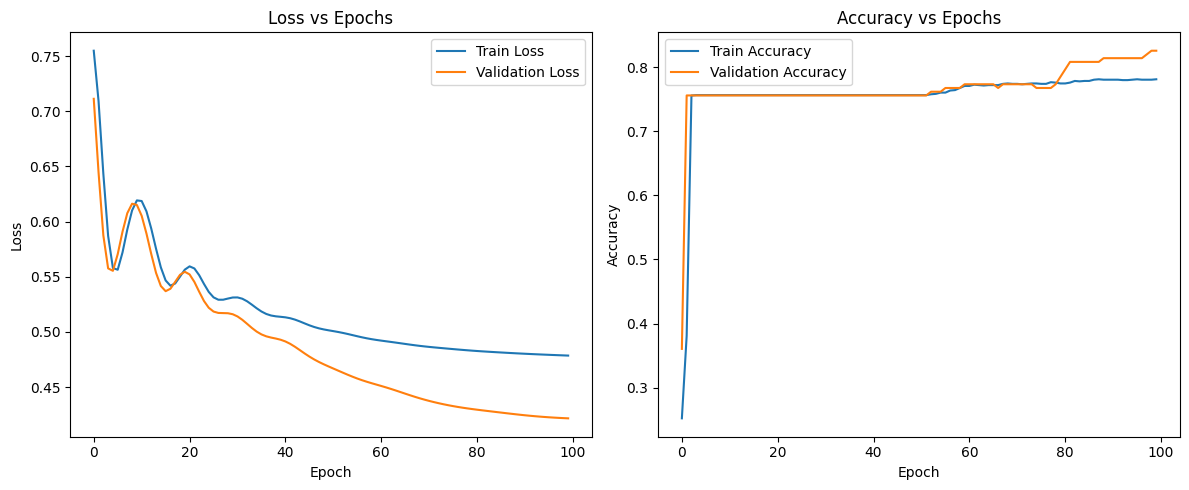

In [248]:
# Entrenar y evaluar el modelo
optimizer_fn = lambda params: torch.optim.SGD(params, lr=0.1, momentum=0.9)
trained_model2 = train_model(input_size, hidden_layers, output_size, activation_fn, loss_fn, optimizer_fn, num_epochs)
del optimizer_fn

Para este modelo observamos que los resultados obtenidos difieren de los que obtuvimos para los modelos 2 y 3. En este caso tuvimos el peor comportamiento para la tasa de aprendizaje 0.1. Notamos además que para esa tasa, con el conjunto de entrenamiento obtenemos mejores resultados que para el conjunto de validación, lo que nos indica que en ese caso es posible que hayamos tenido un sobreajuste con los datos de entrenamiento.

Observamos también que para SGD obtuvimos resultados para el conjunto de entrenamiento y validación que son cercanos en general, aunque no pierden la propiedad de separarse en las epocas más altas.

Entendemos entonces a partir de lo observado que este modelo que mantiene una arquitectura más compleja, se obtienen peores resultados. Y aunque esto podría ir en contra de lo que podríamos esperar, podemos pensar que esto está relacionado a que estamos trabajando con un conjunto de datos que podríamos considerar "no muy grande", y además tal vez estemos trabajando con un conjunto de datos no muy complejo, lo cual puede estar haciendo que se adapten mejor los modelos más simples en comparación con los modelos más complejos que están hechos para aprender relaciones más complejas.

## 2.5 Modelos 2, 3 y 4 sobre el conjunto completo de entrenamiento

Veamos ahora como se comportan los modelos anteriores (con sus mejore optimizadores) sobre el conjunto de entremiento completo:

Epoch 100/100, Training Loss: 0.4634, Validation Loss: 0.4591, Training Accuracy: 0.7873, Validation Accuracy: 0.7944
---------------------------------------------------------------------------
METRICAS recall, precision y F1
Accuracy: 0.794392523364486
Precision: 0.6818181818181818
Recall: 0.28846153846153844
F1: 0.40540540540540543
---------------------------------------------------------------------------


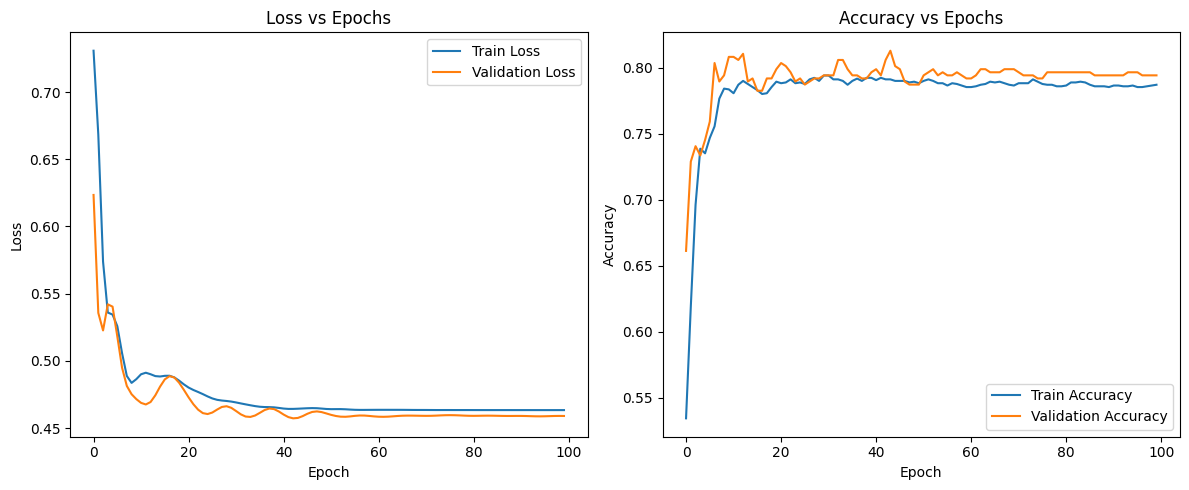

In [255]:
# Modelo 2
input_size = dataset_train_scaled.shape[1] # Número de características de entrada
hidden_layers = [] # No hay capas ocultas
output_size = 2 # Ya que hay dos salidas (una para cada clase).
activation_fn = None # Porque no hay una función de activación después de la capa de salida
loss_fn = nn.CrossEntropyLoss()
optimizer_fn = lambda params: torch.optim.Adam(params, lr=0.1)
num_epochs = 100

# Entrenar y evaluar el modelo
trained_model2_full = train_model(input_size, hidden_layers, output_size, activation_fn, loss_fn, optimizer_fn, num_epochs, True)
del optimizer_fn

Epoch 100/100, Training Loss: 0.4635, Validation Loss: 0.4581, Training Accuracy: 0.7878, Validation Accuracy: 0.7944
---------------------------------------------------------------------------
METRICAS recall, precision y F1
Accuracy: 0.794392523364486
Precision: 0.6818181818181818
Recall: 0.28846153846153844
F1: 0.40540540540540543
---------------------------------------------------------------------------


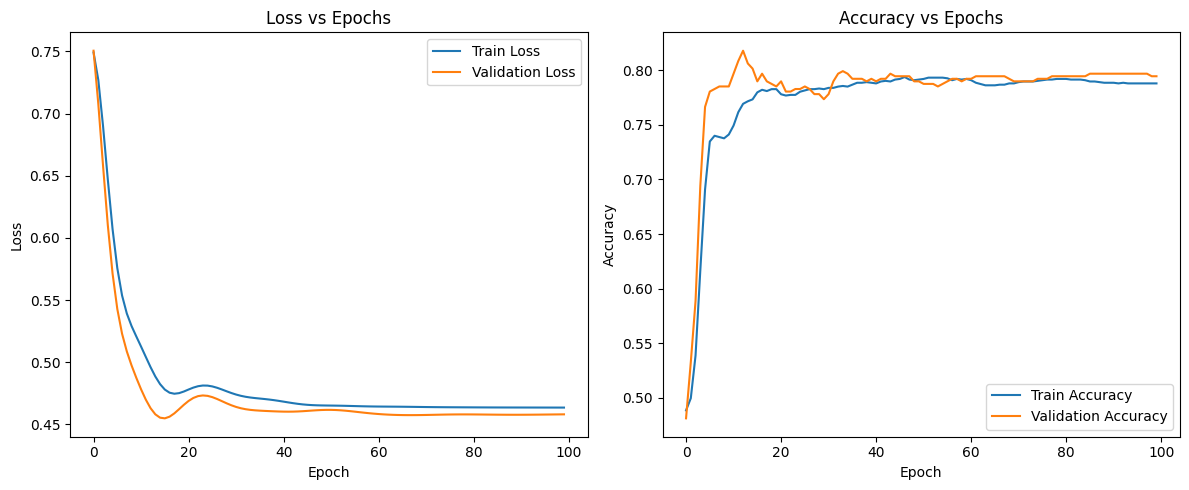

In [254]:
# Modelo 3
input_size = dataset_train_scaled.shape[1]  # Número de características de entrada
hidden_layers = [] # No hay capas ocultas
output_size = 1 # La salida es la probabilidad de una de las clases
activation_fn = nn.Sigmoid()
loss_fn = nn.BCELoss()
optimizer_fn = lambda params: torch.optim.SGD(params, lr=0.1, momentum=0.9)
num_epochs = 100

# Entrenar y evaluar el modelo
trained_model3_full = train_model(input_size, hidden_layers, output_size, activation_fn, loss_fn, optimizer_fn, num_epochs, True)
del optimizer_fn

Epoch 100/100, Training Loss: 0.3541, Validation Loss: 0.4832, Training Accuracy: 0.8615, Validation Accuracy: 0.7780
---------------------------------------------------------------------------
METRICAS recall, precision y F1
Accuracy: 0.7780373831775701
Precision: 0.5616438356164384
Recall: 0.3942307692307692
F1: 0.4632768361581921
---------------------------------------------------------------------------


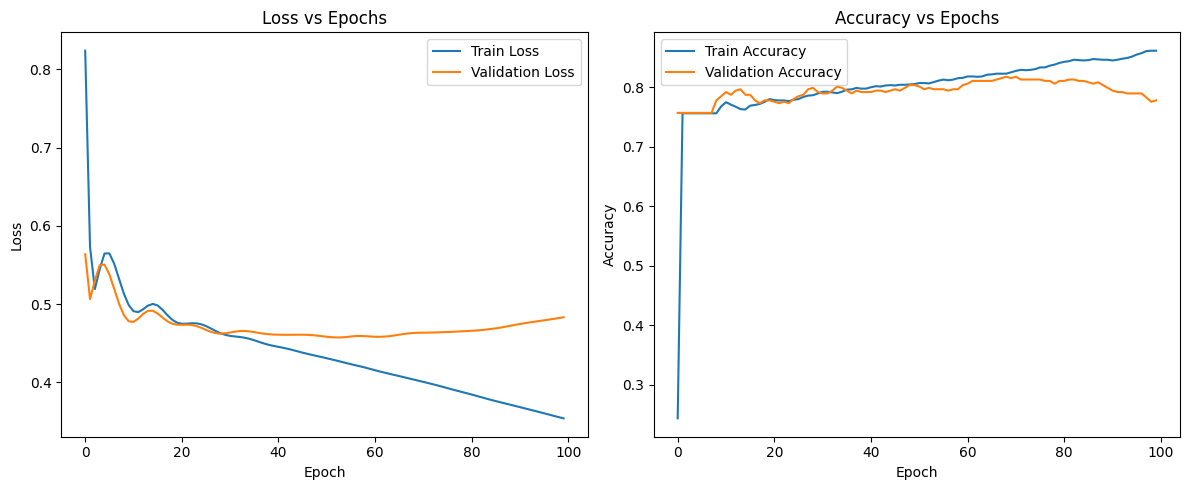

In [256]:
# Modelo 4
input_size = dataset_train_scaled.shape[1]  # Número de características de entrada
hidden_layers = [16]  # Aquí se puede agregar más capas, por ejemplo, [16, 32] para dos capas ocultas
output_size = 1  # La salida es la probabilidad de una de las clases
activation_fn = nn.Sigmoid()
loss_fn = nn.BCELoss()
optimizer_fn = lambda params: torch.optim.Adam(params, lr=0.1)
num_epochs = 100

# Entrenar y evaluar el modelo
trained_model4_full = train_model(input_size, hidden_layers, output_size, activation_fn, loss_fn, optimizer_fn, num_epochs, True)
del optimizer_fn

## 2.6 Experimentando con diferentes arquitecturas

A partir de los resultados anteriores, en esta sección propondremos tres arquitecturas adicionales que busquen mejorar los resultados, modificando la cantidad de unidades, la cantidad de capas ocultas, y/o diferentes funciones de activación. Para cada una, evaluaremos
sus rendimientos sobre el conjunto de validación, con diferentes valores de tasa de aprendizaje. Llamaremos Modelo 5 al modelo con mejores
resultados sobre el conjunto de validación.

### Arquitectura 1 (sin función de activación, capa oculta de 16 unidades, 1 salida)
La Arquitectura 1 fue diseñada para observar el efecto de incluir una capa oculta en una red sin función de activación en la salida. Este modelo buscaba analizar si agregar una capa oculta con 16 unidades permitía captar relaciones menos directas en los datos. Con esta configuración, se lograron resultados prometedores, con una accuracy de hasta 77.06% en entrenamiento y 84.30% en validación, utilizando una tasa de aprendizaje de 0.001.

Para investigar más a fondo, se experimentó con diferentes tasas de aprendizaje. Con una tasa de 0.01, se observó un ligero aumento en el rendimiento, alcanzando un 84.88% de accuracy en validación y un 78.10% en entrenamiento, lo que sugiere que este valor permite al modelo optimizarse mejor sin converger demasiado rápido. Al aumentar la tasa de aprendizaje a 0.1, el modelo mantuvo los resultados en validación con una accuracy de 84.88%.

Estos resultados muestran que la Arquitectura 1 es capaz de captar patrones importantes con esta capa oculta, y que es sensible a la elección de tasa de aprendizaje, logrando un rendimiento adecuado entre 0.001 y 0.1.


-------------------------------------------------------------------------------------------
Entrenando modelo 5.1 con tasa de aprendizaje: 0.001
Epoch 100/100, Training Loss: -0.0000, Validation Loss: -0.0000, Training Accuracy: 0.3528, Validation Accuracy: 0.3198


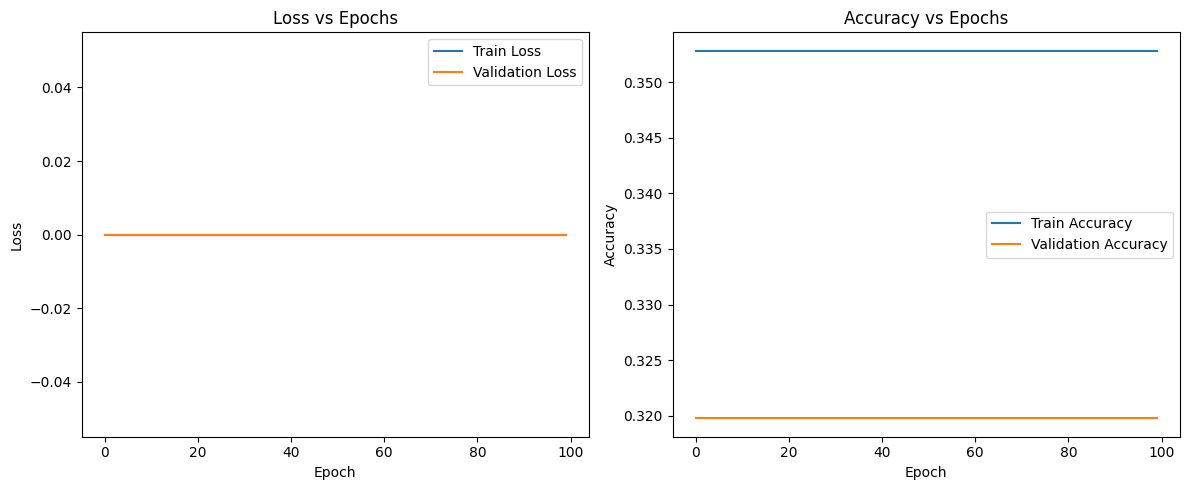

-------------------------------------------------------------------------------------------
Entrenando modelo 5.1 con tasa de aprendizaje: 0.01
Epoch 100/100, Training Loss: -0.0000, Validation Loss: -0.0000, Training Accuracy: 0.2671, Validation Accuracy: 0.2384


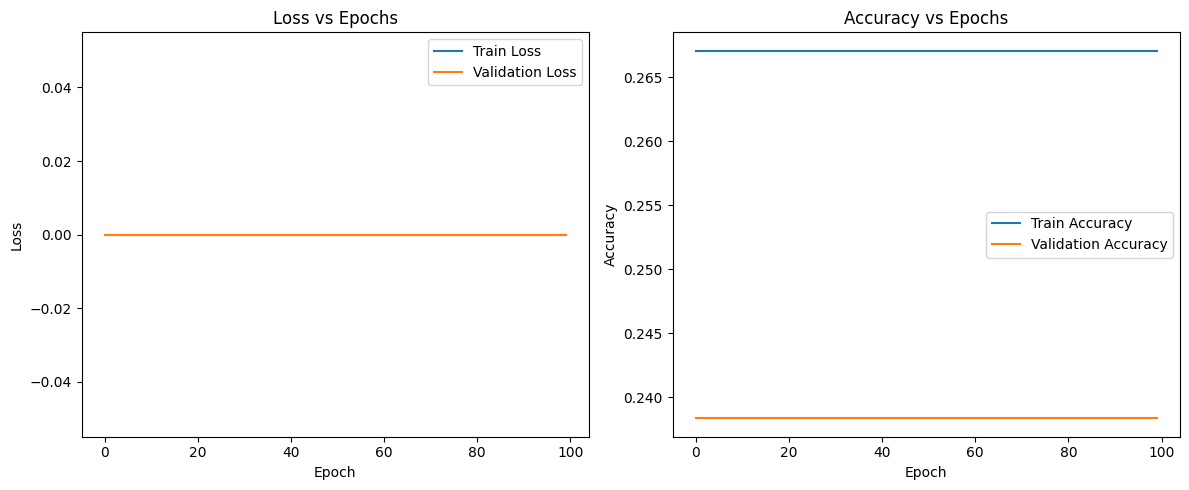

-------------------------------------------------------------------------------------------
Entrenando modelo 5.1 con tasa de aprendizaje: 0.1
Epoch 100/100, Training Loss: -0.0000, Validation Loss: -0.0000, Training Accuracy: 0.5627, Validation Accuracy: 0.5814


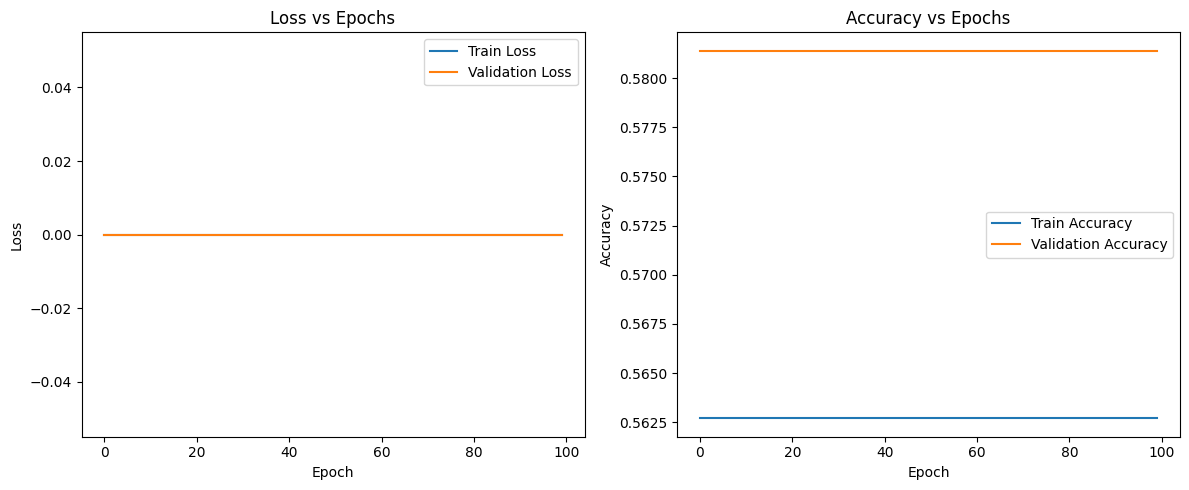

In [259]:
learning_rates = [0.001, 0.01, 0.1]

# Modelo 5.1
input_size = dataset_train_scaled.shape[1]
hidden_layers = [16]
output_size = 1
activation_fn = None
loss_fn = nn.CrossEntropyLoss()
optimizer_fn = lambda params: torch.optim.Adam(params, lr=0.01)
num_epochs = 100

for lr in learning_rates:
    print("-------------------------------------------------------------------------------------------")
    print(f"Entrenando modelo 5.1 con tasa de aprendizaje: {lr}")
    optimizer_fn = lambda params: torch.optim.Adam(params, lr=lr)
    trained_model51 = train_model(input_size, hidden_layers, output_size, activation_fn, loss_fn, optimizer_fn, num_epochs)

del optimizer_fn, loss_fn

### Arquitectura 2 (2 salidas, sin función de activación, 2 capas ocultas de 16 unidades cada una)

La Arquitectura 2 se diseñó basada en el buen desempeño del Modelo 2, el cual demostró que tener una salida específica para cada clase permite tener una buena accuracy (83.14% en este modelo). Para esta arquitectura, se agregaron dos capas ocultas de 16 unidades cada una, intentando incrementar la capacidad de analisis de patrones complejos, pero esto ya no impactó de forma significativa (de hecho la accuracy fue levemente menor que la de la arquitectura 1).

Las pruebas con diferentes tasas de aprendizaje mostraron que la arquitectura es bastante robusta a estos cambios, alcanzando una accuracy de hasta 84.30% con una tasa de aprendizaje de 0.1.


-------------------------------------------------------------------------------------------
Entrenando modelo 5.2 con tasa de aprendizaje: 0.001
Epoch 100/100, Training Loss: 0.5875, Validation Loss: 0.5835, Training Accuracy: 0.7550, Validation Accuracy: 0.7558


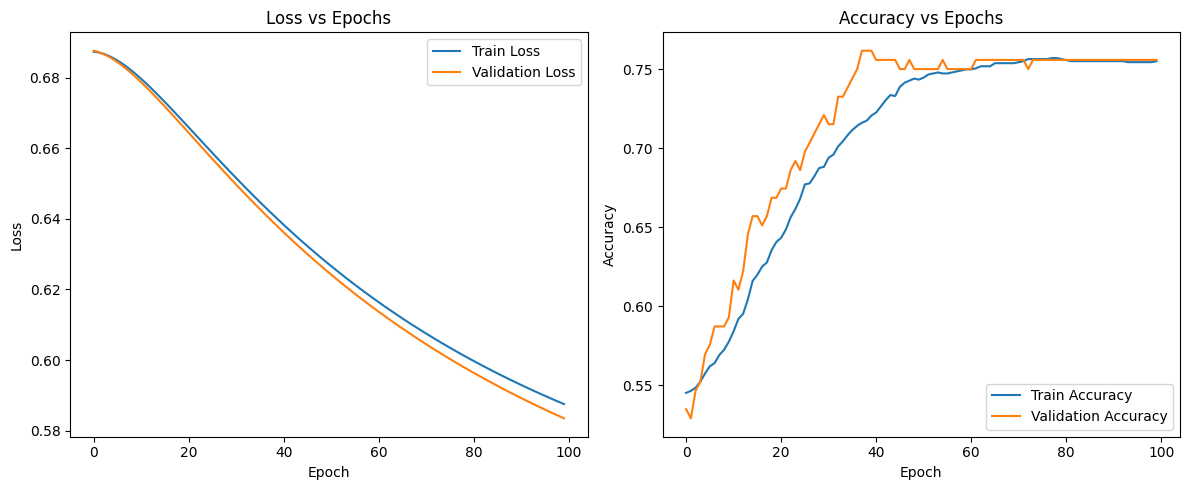

-------------------------------------------------------------------------------------------
Entrenando modelo 5.2 con tasa de aprendizaje: 0.01
Epoch 100/100, Training Loss: 0.4797, Validation Loss: 0.4348, Training Accuracy: 0.7758, Validation Accuracy: 0.8023


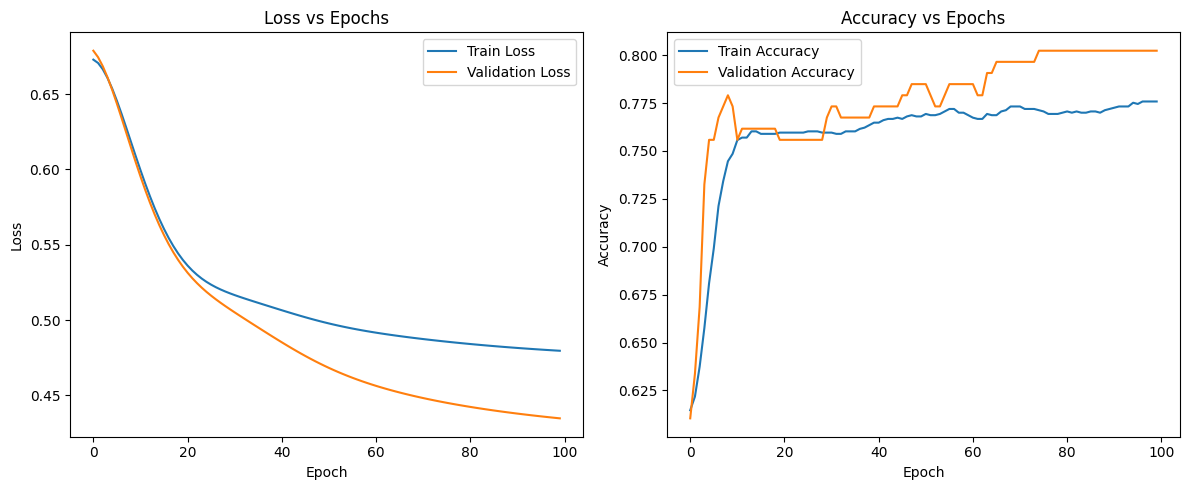

-------------------------------------------------------------------------------------------
Entrenando modelo 5.2 con tasa de aprendizaje: 0.1
Epoch 100/100, Training Loss: 0.4698, Validation Loss: 0.4169, Training Accuracy: 0.7836, Validation Accuracy: 0.8430


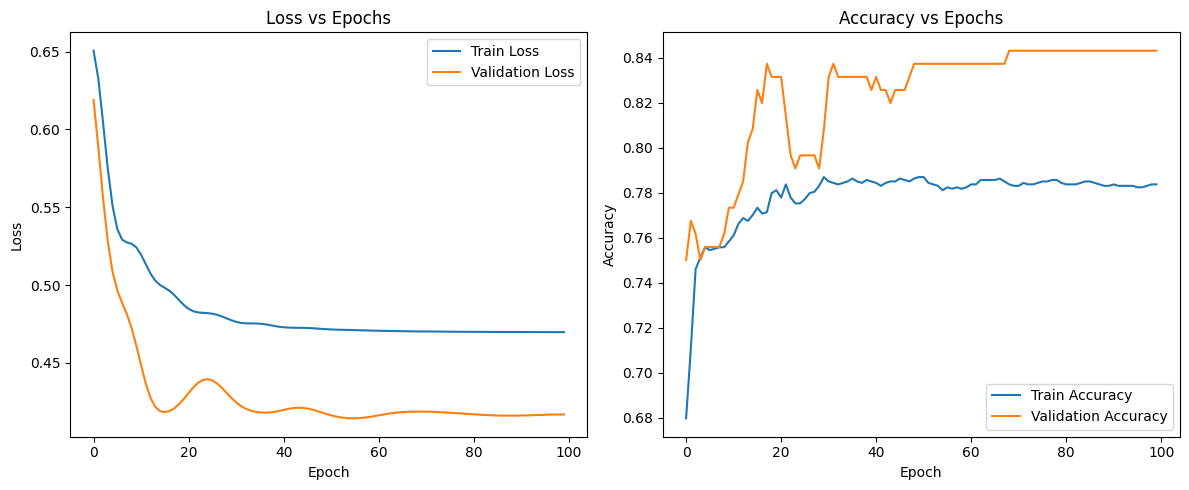

In [258]:
input_size = dataset_train_scaled.shape[1]
hidden_layers = [16, 16]
output_size = 2
activation_fn = None
loss_fn = nn.CrossEntropyLoss()
optimizer_fn = lambda params: torch.optim.SGD(params, lr=0.01, momentum=0.9)
num_epochs = 100

for lr in learning_rates:
    print("-------------------------------------------------------------------------------------------")
    print(f"Entrenando modelo 5.2 con tasa de aprendizaje: {lr}")
    optimizer_fn = lambda params: torch.optim.SGD(params, lr=lr, momentum=0.9)
    trained_model52 = train_model(input_size, hidden_layers, output_size, activation_fn, loss_fn, optimizer_fn, num_epochs)

del optimizer_fn, loss_fn

### Arquitectura 3 (función de activación sigmoide, sin capas ocultas, 2 salidas)

Para la Arquitectura 3, se utilizó una sola capa con dos salidas y una función de activación sigmoide, lo cual creemos que fue efectivo en los modelos previos. Se mantuvo la idea de utilizar dos salidas independientes para cada clase, optimizando así el aprendizaje de probabilidades para cada una.

Al variar las tasas de aprendizaje, el modelo mostró que responde favorablemente a estas modificaciones, alcanzando una accuracy de validación de 84.88% con una tasa de 0.1. Esto sugiere que tener dos salidas y una activación sigmoide es una configuración poderosa y flexible en términos de aprendizaje.


In [ ]:
input_size = dataset_train_scaled.shape[1]
hidden_layers = []
output_size = 2
activation_fn = nn.Sigmoid()
loss_fn = nn.CrossEntropyLoss()
optimizer_fn = lambda params: torch.optim.SGD(params, lr=0.01, momentum=0.9)
num_epochs = 100

for lr in learning_rates:
    print("-------------------------------------------------------------------------------------------")
    print(f"Entrenando modelo 5.3 con tasa de aprendizaje: {lr}")
    optimizer_fn = lambda params: torch.optim.SGD(params, lr=lr, momentum=0.9)
    trained_model53 = train_model(input_size, hidden_layers, output_size, activation_fn, loss_fn, optimizer_fn, num_epochs)

# Codigo utilizado para la sección "Comparación entre los 5 modelos, ID3 y Naive Bayes"
trained_model53_full = train_model(input_size, hidden_layers, output_size, activation_fn, loss_fn, optimizer_fn, num_epochs, True)

del optimizer_fn, loss_fn
del trained_model51, trained_model52, trained_model53, trained_model53_full
torch.cuda.empty_cache()

### Elección de Modelo 5

Finalmente decidimos que nuestro “Modelo 5” sería el entrenado con la arquitectura 3. Además de que demostró ser levemente mejor en casi todas las tasas de aprendizaje, lo elegimos porque creemos que el factor crucial del mejor rendimiento es tener dos salidas, dado que el modelo aprende a estimar una probabilidad independiente para cada clase. Esto le permite ajustar el valor para cada clase de forma más explícita, no dependiendo de transformar la única salida en una probabilidad para una clase y deducir la otra por complementariedad, lo que le da más flexibilidad en su proceso de aprendizaje. Además, tener una capa sola ha demostrado ser mejor en los modelos 2, 3 y 4, lo cual también aportó en la decisión. 

## 2.7 Comparación entre los 5 modelos, ID3 y Naive Bayes

A continuación procedemos a mostrar los resultados de las métricas accuracy, precision, recall y medida F1 de los 5 modelos, ID3 y Naive Bayes. Para ello agregamos el parámetro "full_evaluation" al método "train_model", el cual permite entrenar los modelos con el conjunto completo de entrenamiento y evaluar su rendimiento en el conjunto completo de evaluación (usando los conjuntos definidos en la sección 2.1, como "dataset_train_full", "dataset_test", "target_train_full", "target_test"). 

A considerar:

- La medida F1 de los modelos ID3 y NB fueron calculados a mano a partir de los resultados de accuracy y presición que se mostraron en el informe del laboratorio 2.
- Estos valores fueron obtenidos de las ejecuciones en las secciones previas (por ejemplo, al ejecutar "train_model" con el parametro de  "full_evaluation" para el modelo 5).


|  Modelo   | Exactitud | Presición | Recuperación | F1 |
|-----|----------:|----------:|----:| ----:|
| 1 (RL) |   0.80  | 0.70 | 0.29 | 0.41 |
| 2 |   0.79    | 0.71 | 0.26 | 0.38 |
| 3 |   0.79    | 0.74 | 0.24 | 0.36 |
| 4 |   0.79    | 0.68 |0.25 | 0.37 |
| 5 |   0.79    | 0.68 |0.29 | 0.41 |
| ID3 |   0.79    | 0.60 | 0.40| 0,48 |
| NB |   0.78    | 0.57 |0.28 | 0.37 |

#### Exactitud
En términos de exactitud, no existen grandes diferencias entre todos los modelos. Regresión Logística (RL) obtiene el mayor puntaje de exactitud con un 0.80, aunque los modelos 2 a 5 y el modelo ID3 también se desempeñan bastante bien con una exactitud del 0.79. El modelo Naive Bayes (NB) tiene el puntaje de exactitud más bajo, alcanzando un 0.78.
Esta métrica sugiere que RL tiene un leve rendimiento superior en términos de exactitud sobre los otros modelos.

#### Precisión
Modelos 2 y 3 destacan en términos de precisión, logrando un puntaje de 0.71 y 0.74 respectivamente. La precisión es la capacidad del modelo de minimizar los falsos positivos, lo que sugiere que estos modelos son más cautelosos al clasificar instancias y evitan en mayor medida clasificaciones incorrectas.
Naive Bayes (NB) muestra la precisión más baja (0.57), lo que implica que este modelo es menos confiable para predecir correctamente clases cuando está seguro de su predicción.
Los otros modelos se encuentran en un rango intermedio (0.60-0.70), lo que sugiere que todos, excepto NB, tienen un rendimiento aceptable en precisión.

#### Recuperación
ID3 destaca con la mayor recuperación (0.40), lo que significa que es el mejor en identificar correctamente las instancias positivas, minimizando los falsos negativos. Esto indica que el modelo ID3 tiene cierta ventaja en su capacidad para capturar todas las clases relevantes.
RL, Naive Bayes, y los modelos 2 a 5 obtienen recuperaciones más bajas, oscilando entre 0.24 y 0.29. Esto implica que estos modelos pueden estar dejando pasar instancias que deberían clasificarse positivamente, lo que sugiere que sacrifican cierta cobertura en favor de precisión.

#### Medida F1
ID3 y RL logran las mejores puntuaciones F1, con valores de 0.48 y 0.41, respectivamente. Esto indica un equilibrio razonable entre precisión y recuperación en estos modelos, siendo ID3 ligeramente superior debido a su mejor recuperación.
Naive Bayes y los modelos restantes tienen F1 inferiores (entre 0.36 y 0.38), lo que indica que estos modelos están menos equilibrados entre precisión y recuperación. Esto puede ser un indicio de que pueden estar clasificando incorrectamente tanto falsos positivos como falsos negativos en mayor medida.


# 3. Conclusión

##### Con respecto a la comparación de los 5 modelos, NB e ID3: 

El mejor desempeño general lo tuvo el modelo de regresión logística (RL) mostrando un buen balance general entre las métricas, liderando en exactitud y manteniéndose competitiva en precisión y F1.

ID3 es el mejor modelo en términos de recuperación y F1, aunque su precisión y exactitud no son las mejores. Esto lo hace adecuado para casos donde es prioritario no perder instancias relevantes, incluso a costa de algunos falsos positivos.

Los modelos menos recomendados desde nuestro punto de vista son Naive Bayes y los modelos 2 a 5 ya que muestran un rendimiento inferior en varias métricas, especialmente en recuperación y F1, lo que sugiere que podrían no ser ideales para un balance entre clasificación correcta y cobertura de todas las instancias.